# NYC Rat Risk: 
### Being Proactive on Rats in NYC

## Retreive Data

In [134]:
import pandas as pd

RATS_URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$select=unique_key,created_date,descriptor,borough,latitude,longitude&$where=complaint_type%3D%27Rodent%27&$limit=500000"
DUMPING_URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$select=unique_key,created_date,descriptor,borough,latitude,longitude&$where=complaint_type%3D%27Illegal%20Dumping%27&$limit=500000"

df_rats = pd.read_csv(RATS_URL)
df_dumping = pd.read_csv(DUMPING_URL)

In [78]:
df_rats.sort_values(by='created_date')

unique_key             created_date                    descriptor  \
490802    15633803  2010-01-01T08:29:58.000                  Rat Sighting   
490801    15633054  2010-01-01T11:20:45.000                  Rat Sighting   
490800    15633965  2010-01-01T12:11:44.000  Condition Attracting Rodents   
490799    15633896  2010-01-01T12:11:51.000                  Rat Sighting   
490798    15633897  2010-01-01T12:12:04.000                  Rat Sighting   
...            ...                      ...                           ...   
4         66928596  2025-11-23T19:29:35.000                  Rat Sighting   
3         66931995  2025-11-23T19:39:31.000  Condition Attracting Rodents   
2         66933119  2025-11-23T23:44:11.000  Condition Attracting Rodents   
1         66933122  2025-11-24T00:16:10.000                Mouse Sighting   
0         66935275  2025-11-24T01:07:57.000                  Rat Sighting   

          borough   latitude  longitude  
490802   BROOKLYN  40.692989 -73.943771  
490801     QUEENS  40.739983 -73.809299  
490800     QUEENS  40.674091 -73.808377  
490799  MANHATTAN  40.807367 -73.954388  
490798      BRONX  40.855513 -73.890006  
...           ...        ...        ...  
4          QUEENS  40.745663 -73.899206  
3        BROOKLYN  40.651460 -73.954048  
2        BROOKLYN  40.633076 -73.950965  
1        BROOKLYN  40.633076 -73.950965  
0        BROOKLYN  40.633507 -74.003171  

[490803 rows x 6 columns]

In [79]:
df_dumping.sort_values(by='created_date')

unique_key             created_date       descriptor        borough  \
145873    51944741  2021-09-21T22:26:19.000  Removal Request          BRONX   
145872    51936932  2021-09-21T22:47:17.000  Removal Request       BROOKLYN   
145871    51938287  2021-09-21T22:52:48.000  Removal Request       BROOKLYN   
145870    51939578  2021-09-21T23:43:57.000  Removal Request  STATEN ISLAND   
145869    51943484  2021-09-21T23:58:36.000  Removal Request       BROOKLYN   
...            ...                      ...              ...            ...   
4         66933041  2025-11-23T21:39:15.000  Removal Request         QUEENS   
3         66927437  2025-11-23T21:44:31.000  Removal Request         QUEENS   
2         66928520  2025-11-23T22:43:47.000  Removal Request       BROOKLYN   
1         66933035  2025-11-24T00:15:35.000  Removal Request          BRONX   
0         66928522  2025-11-24T00:43:34.000  Removal Request       BROOKLYN   

         latitude  longitude  
145873  40.815988 -73.926091  
145872  40.655021 -73.897329  
145871  40.652086 -73.938147  
145870  40.578048 -74.109468  
145869  40.725545 -73.945103  
...           ...        ...  
4       40.762351 -73.818476  
3       40.603087 -73.760494  
2       40.681163 -73.895118  
1       40.832559 -73.928305  
0       40.625538 -73.932206  

[145874 rows x 6 columns]

## Data Cleaning

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
RELIABLE_START_DATE = '2022-01-01'
CLEAN_DATE_COL = 'Created Date' # Define a clean name for the final date column
PRECISION = 4 # Geospatial rounding precision (proxy for block size)


# ====================================================================
# NOTE: ASSUMPTION
# df_rats and df_dumping DataFrames are already loaded into
# your environment from the successful execution of the Socrata API query.
# ====================================================================

# --- Configuration & Safety Check ---
try:
    if 'df_rats' not in locals() or 'df_dumping' not in locals():
        raise NameError("df_rats or df_dumping not found.")
except Exception as e:
    print(f"Error during initial data check: {e}")

# --- 1. Data Cleaning and Preparation ---

# Define the expected raw date column name from the API.
RAW_DATE_COL = 'created_date'

COL_MAP = {
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'unique_key': 'Unique Key',
    'borough': 'Borough'
}

df_rats.rename(columns=COL_MAP, inplace=True)
df_dumping.rename(columns=COL_MAP, inplace=True)

# Drop the old 'Created Date' if it exists
if CLEAN_DATE_COL in df_rats.columns:
    df_rats.drop(columns=[CLEAN_DATE_COL], inplace=True)
if CLEAN_DATE_COL in df_dumping.columns:
    df_dumping.drop(columns=[CLEAN_DATE_COL], inplace=True)

# Reset the index
df_rats = df_rats.reset_index(drop=True)
df_dumping = df_dumping.reset_index(drop=True)


# Explicitly convert the date using the expected raw column name.
SOCRATA_DATE_FORMAT = '%Y-%m-%dT%H:%M:%S.%f'

try:
    if RAW_DATE_COL not in df_rats.columns or RAW_DATE_COL not in df_dumping.columns:
        raise KeyError(f"The required date column '{RAW_DATE_COL}' is missing.")

    df_rats.loc[:, CLEAN_DATE_COL] = pd.to_datetime(
        df_rats[RAW_DATE_COL].apply(str),
        format=SOCRATA_DATE_FORMAT,
        errors='coerce'
    )

    df_dumping.loc[:, CLEAN_DATE_COL] = pd.to_datetime(
        df_dumping[RAW_DATE_COL].apply(str),
        format=SOCRATA_DATE_FORMAT,
        errors='coerce'
    )

except KeyError as e:
    print(f"\n--- CRITICAL COLUMN ERROR ---")
    print(f"KeyError: {e}. Cannot proceed without '{RAW_DATE_COL}'.")
    raise

# Drop the raw string column
df_rats.drop(columns=[RAW_DATE_COL], inplace=True)
df_dumping.drop(columns=[RAW_DATE_COL], inplace=True)


# Add the incident type and concatenate
df_rats['incident_type'] = 'rat_sighting'
df_dumping['incident_type'] = 'illegal_dumping'

# **df_incidents_full** holds the complete, unfiltered history
df_incidents_full = pd.concat([df_rats, df_dumping], ignore_index=True)

# Drop records missing location or date data
df_incidents_full = df_incidents_full.dropna(subset=['Latitude', 'Longitude', CLEAN_DATE_COL])

print(f"Total incidents processed (pre-filter): {len(df_incidents_full)} records.")

# --- 2. Geospatial Aggregation (FULL DATA) ---
print("Aggregating incidents using coordinate gridding (FULL history)...")

df_incidents_full['Block_Lat'] = df_incidents_full['Latitude'].round(PRECISION)
df_incidents_full['Block_Lon'] = df_incidents_full['Longitude'].round(PRECISION)
df_incidents_full['Block_ID'] = df_incidents_full['Block_Lat'].astype(str) + "_" + df_incidents_full['Block_Lon'].astype(str)

df_incidents_full['Month_Year'] = df_incidents_full[CLEAN_DATE_COL].dt.to_period('M')

# df_aggregated_full is created here for the Time Series Plot
df_aggregated_full = df_incidents_full.groupby(['Block_ID', 'Month_Year', 'incident_type']).size().unstack(fill_value=0)
df_aggregated_full.columns = [f'count_{c}' for c in df_aggregated_full.columns]
df_aggregated_full = df_aggregated_full.reset_index()

if 'count_rat_sighting' not in df_aggregated_full.columns:
    df_aggregated_full['count_rat_sighting'] = 0
if 'count_illegal_dumping' not in df_aggregated_full.columns:
    df_aggregated_full['count_illegal_dumping'] = 0

df_aggregated_full['total_incidents'] = df_aggregated_full['count_rat_sighting'] + df_aggregated_full['count_illegal_dumping']
print(f"Total aggregated records (Block-Months, FULL history): {len(df_aggregated_full)}")


# =================================================================
# --- Filtering for Reliable Data Window (START OF ML DATA PREP) ---
# =================================================================

# Filter the aggregated data for the reliable window (2022-01-01 onward) for ML
df_aggregated_ml = df_aggregated_full[
    pd.to_datetime(df_aggregated_full['Month_Year'].astype(str)) >= RELIABLE_START_DATE
].copy()

print(f"Total aggregated records (Block-Months, FILTERED for ML): {len(df_aggregated_ml)}")

# --- 3. Feature Engineering (Creating Lagged and Time Features) ---
print("\nCreating Lagged Time-Series Features...")

df_aggregated_ml['Month_Start'] = df_aggregated_ml['Month_Year'].dt.to_timestamp()
df_aggregated_ml = df_aggregated_ml.sort_values(by=['Block_ID', 'Month_Start']).reset_index(drop=True)

# Lagged Features
df_aggregated_ml['lag_1_rat'] = df_aggregated_ml.groupby('Block_ID')['count_rat_sighting'].shift(1).fillna(0)
df_aggregated_ml['lag_1_dumping'] = df_aggregated_ml.groupby('Block_ID')['count_illegal_dumping'].shift(1).fillna(0)
df_aggregated_ml['lag_2_rat'] = df_aggregated_ml.groupby('Block_ID')['count_rat_sighting'].shift(2).fillna(0)
df_aggregated_ml['lag_6_rat'] = df_aggregated_ml.groupby('Block_ID')['count_rat_sighting'].shift(6).fillna(0)

# Rolling Average
df_aggregated_ml['lag_3_avg_rat'] = df_aggregated_ml.groupby('Block_ID')['count_rat_sighting'].shift(1).rolling(window=3, min_periods=1).mean().fillna(0)

# Time-based Features
df_aggregated_ml['month'] = df_aggregated_ml['Month_Start'].dt.month
df_aggregated_ml['year'] = df_aggregated_ml['Month_Start'].dt.year

df_features = df_aggregated_ml.copy()

# --- 4. Define Target Variable (Predicting Next Month) ---

RAT_THRESHOLD = df_features['count_rat_sighting'].quantile(0.90)

# Shift the actual incident count BACK by 1 to align it as the NEXT month's target
df_features['next_month_rat_count'] = df_features.groupby('Block_ID')['count_rat_sighting'].shift(-1)

# Drop the last month's data since we can't calculate 'next_month_rat_count' for it
df_features.dropna(subset=['next_month_rat_count'], inplace=True)

# Create the binary target variable (1 = High Risk, 0 = Low Risk)
df_features['TARGET_HIGH_RISK'] = (df_features['next_month_rat_count'] >= RAT_THRESHOLD).astype(int)
print(f"\nTarget Threshold (90th percentile): {RAT_THRESHOLD:.0f} incidents/month")
print(f"Target variable created. High-Risk records: {df_features['TARGET_HIGH_RISK'].sum()}")

Total incidents processed (pre-filter): 631130 records.
Aggregating incidents using coordinate gridding (FULL history)...
Total aggregated records (Block-Months, FULL history): 508791
Total aggregated records (Block-Months, FILTERED for ML): 228979

Creating Lagged Time-Series Features...

Target Threshold (90th percentile): 1 incidents/month
Target variable created. High-Risk records: 63332


In [ ]:
df_features.sort_values(by='Month_Start')

In [82]:
df_features.sort_values(by='Month_Start')

Block_ID Month_Year  count_illegal_dumping  \
177094  40.7977_-73.9334    2022-01                      0   
38036   40.6449_-74.0085    2022-01                      0   
156510  40.7612_-73.9409    2022-01                      1   
25729   40.6304_-74.0799    2022-01                      1   
177370  40.7983_-73.9628    2022-01                      0   
...                  ...        ...                    ...   
130487   40.727_-73.9785    2025-10                      0   
51483   40.6635_-73.9428    2025-10                      0   
51443   40.6635_-73.8138    2025-10                      2   
190384  40.8201_-73.9374    2025-10                      0   
100987   40.6994_-73.947    2025-10                      1   

        count_rat_sighting  total_incidents Month_Start  lag_1_rat  \
177094                   1                1  2022-01-01        0.0   
38036                    1                1  2022-01-01        0.0   
156510                   0                1  2022-01-01        0.0   
25729                    1                2  2022-01-01        0.0   
177370                   2                2  2022-01-01        0.0   
...                    ...              ...         ...        ...   
130487                   1                1  2025-10-01        1.0   
51483                    2                2  2025-10-01        1.0   
51443                    0                2  2025-10-01        0.0   
190384                   1                1  2025-10-01        1.0   
100987                   0                1  2025-10-01        1.0   

        lag_1_dumping  lag_2_rat  lag_6_rat  lag_3_avg_rat  month  year  \
177094            0.0        0.0        0.0            1.0      1  2022   
38036             0.0        0.0        0.0            2.5      1  2022   
156510            0.0        0.0        0.0            0.0      1  2022   
25729             0.0        0.0        0.0            0.0      1  2022   
177370            0.0        0.0        0.0            1.0      1  2022   
...               ...        ...        ...            ...    ...   ...   
130487            0.0        1.0        0.0            1.0     10  2025   
51483             0.0        1.0        1.0            1.0     10  2025   
51443             2.0        0.0        0.0            0.0     10  2025   
190384            0.0        1.0        3.0            1.0     10  2025   
100987            0.0        0.0        0.0            0.5     10  2025   

        next_month_rat_count  TARGET_HIGH_RISK  
177094                   0.0                 0  
38036                    1.0                 1  
156510                   0.0                 0  
25729                    0.0                 0  
177370                   2.0                 1  
...                      ...               ...  
130487                   1.0                 1  
51483                    4.0                 1  
51443                    0.0                 0  
190384                   1.0                 1  
100987                   0.0                 0  

[115962 rows x 15 columns]

## EDA

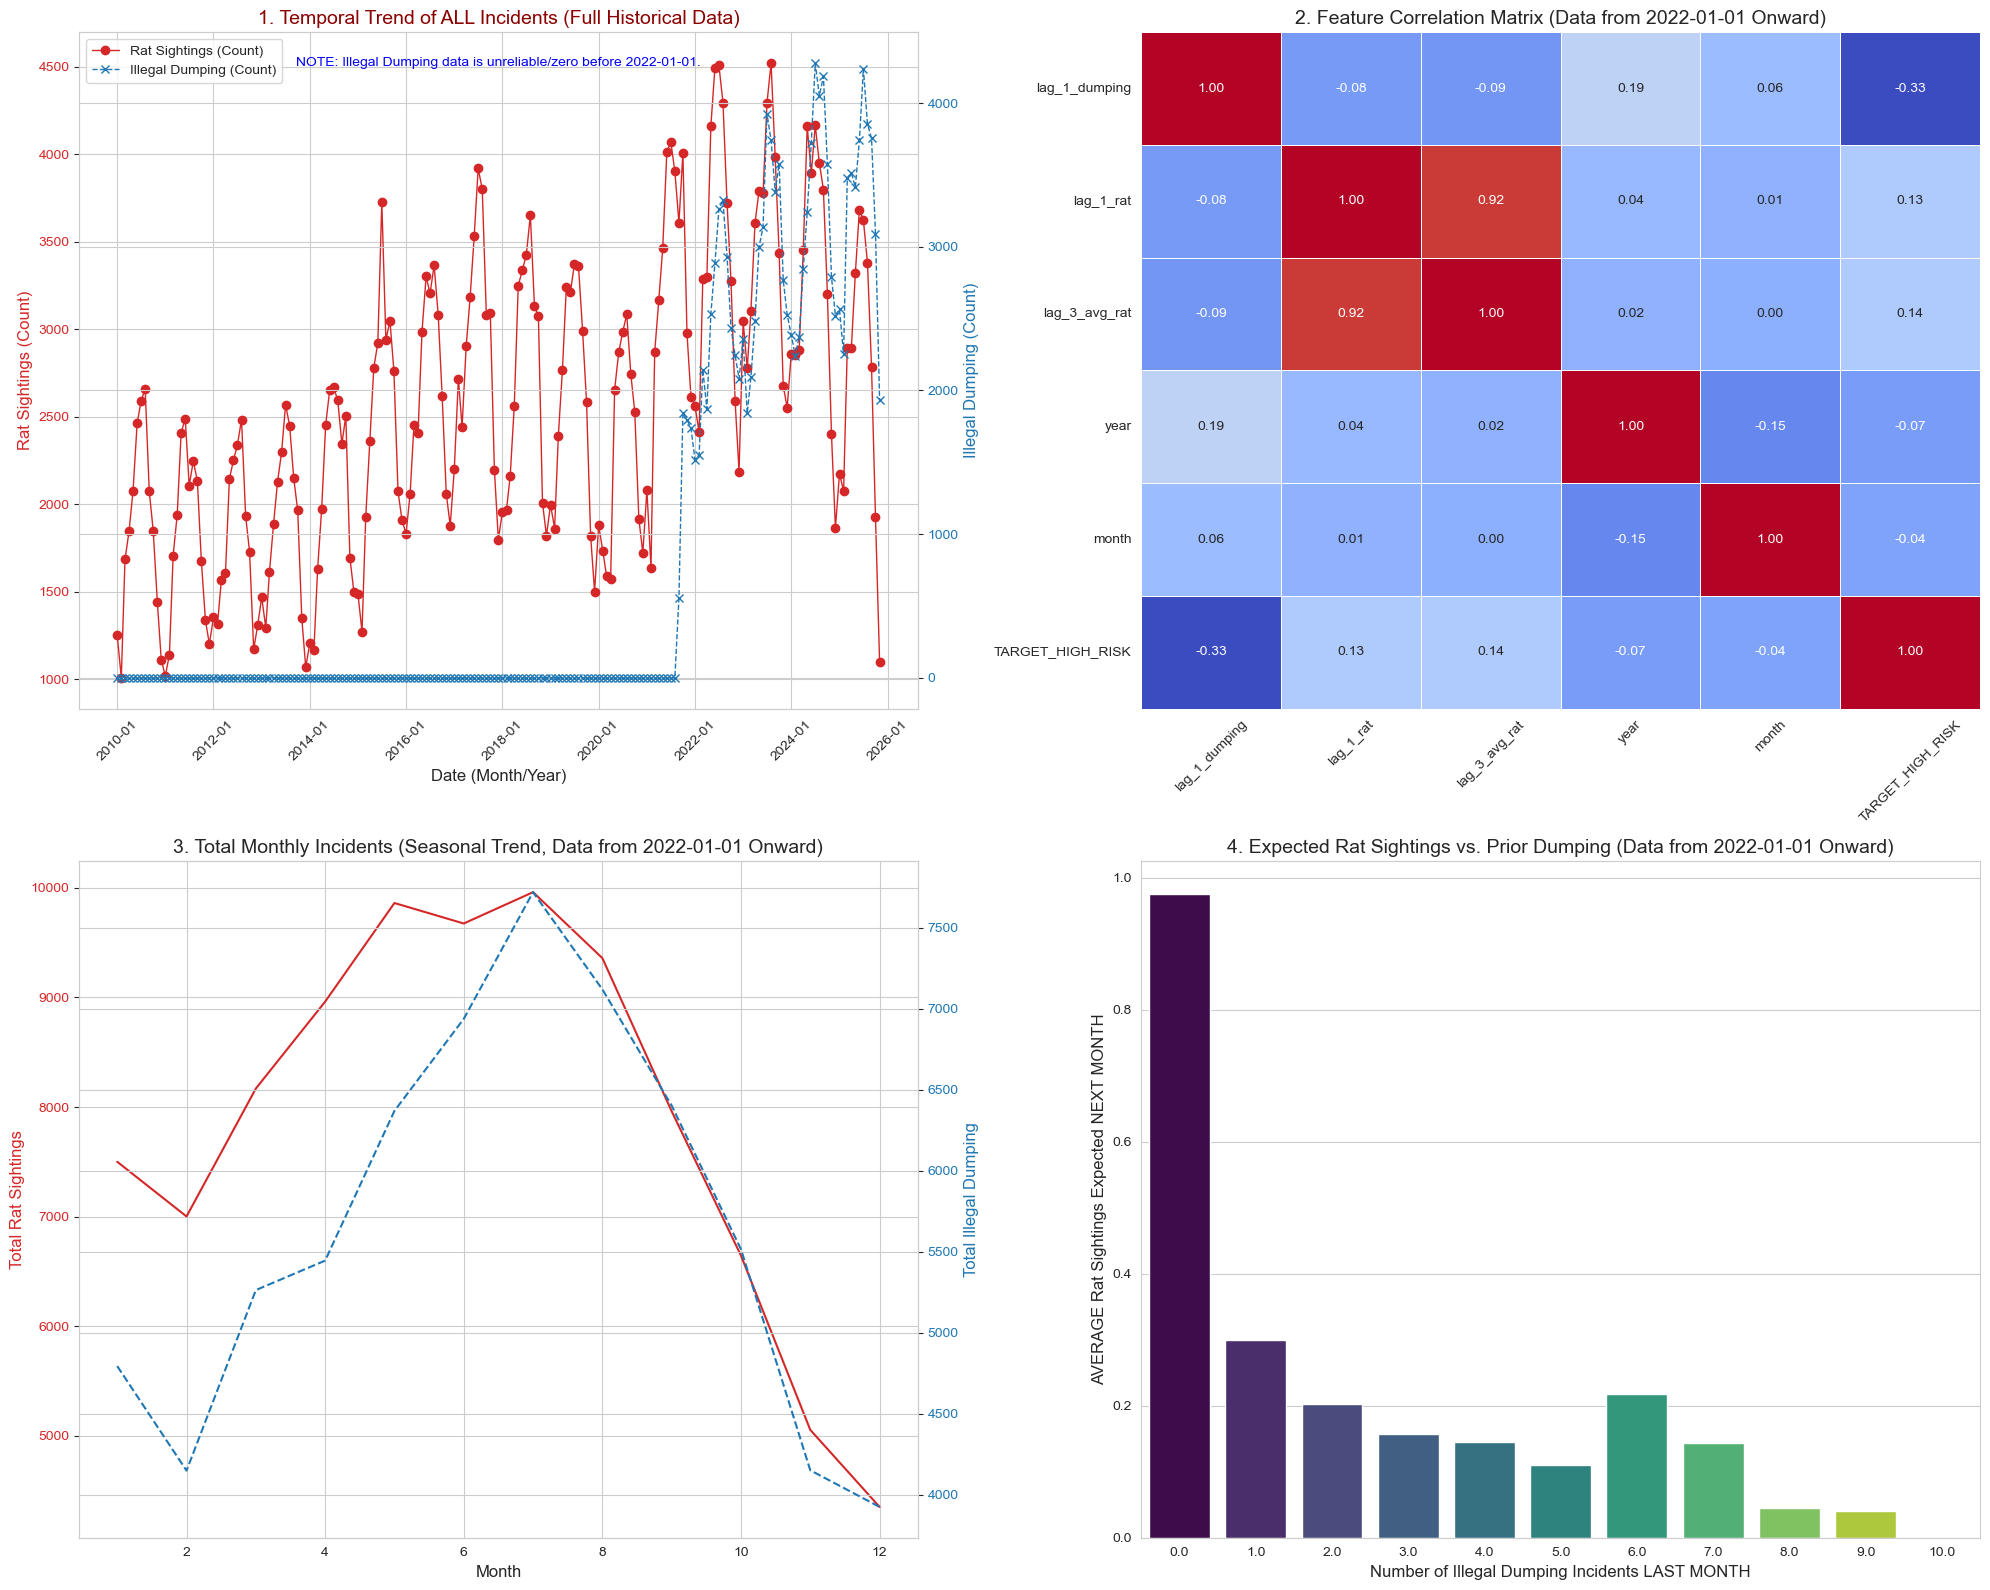

In [84]:
# Create the filtered DataFrame for correlation and trend analysis
# df_features contains the final, filtered, lagged data for ML (2022-01-01 onwards)
df_features_filtered = df_features.copy()

# Set visual style and create the figure with 2 rows and 2 columns
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# ====================================================================
# --- SUBPLOT 1 (axes[0]): Time Series of Counts (FULL DATA - CRITICAL FOR CONTEXT) ---
# ====================================================================

# Preparation for FULL time series (using df_aggregated_full created in the prior block)
time_series_data_full = df_aggregated_full.groupby('Month_Year')[
    ['count_rat_sighting', 'count_illegal_dumping']
].sum().reset_index()

# Convert Month_Year period to datetime for plotting
time_series_data_full['date'] = time_series_data_full['Month_Year'].dt.to_timestamp()

ax_ts = axes[0]

# Plot Rat Sightings
color_rat = 'tab:red'
ax_ts.plot(time_series_data_full['date'], time_series_data_full['count_rat_sighting'], color=color_rat, label='Rat Sightings (Count)', marker='o', linewidth=1)
ax_ts.set_ylabel('Rat Sightings (Count)', color=color_rat, fontsize=12)
ax_ts.tick_params(axis='y', labelcolor=color_rat)

# Create twin axis for Illegal Dumping
ax_ts_2 = ax_ts.twinx()
color_dumping = 'tab:blue'
ax_ts_2.plot(time_series_data_full['date'], time_series_data_full['count_illegal_dumping'], color=color_dumping, label='Illegal Dumping (Count)', linestyle='--', marker='x', linewidth=1)
ax_ts_2.set_ylabel('Illegal Dumping (Count)', color=color_dumping, fontsize=12)
ax_ts_2.tick_params(axis='y', labelcolor=color_dumping)

# Common settings for Time Series plot
ax_ts.set_xlabel('Date (Month/Year)', fontsize=12)
ax_ts.set_title('1. Temporal Trend of ALL Incidents (Full Historical Data)', fontsize=14, color='darkred')
ax_ts.text(0.5, 0.95, f'NOTE: Illegal Dumping data is unreliable/zero before {RELIABLE_START_DATE}.',
           transform=ax_ts.transAxes, fontsize=10, color='blue', ha='center')

# Format the x-axis to show month/year nicely and rotate for readability
ax_ts.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax_ts.tick_params(axis='x', rotation=45)

# Add a combined legend
lines, labels = ax_ts.get_legend_handles_labels()
lines2, labels2 = ax_ts_2.get_legend_handles_labels()
ax_ts.legend(lines + lines2, labels + labels2, loc='upper left')


# ====================================================================
# --- SUBPLOT 2 (axes[1]): Correlation Matrix (FILTERED DATA) ---
# ====================================================================

corr_cols = [
    'lag_1_dumping',
    'lag_1_rat',
    'lag_3_avg_rat',
    'year',
    'month',
    'TARGET_HIGH_RISK'
]

# *** Uses df_features_filtered (Jan 2022+ data) ***
corr_matrix = df_features_filtered[corr_cols].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    ax=axes[1],
    cbar=False
)
axes[1].set_title(f'2. Feature Correlation Matrix (Data from {RELIABLE_START_DATE} Onward)', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

# ====================================================================
# --- SUBPLOT 3 (axes[2]): Temporal Trend of Incidents (Monthly) (FILTERED DATA) ---
# ====================================================================

# *** Uses df_features_filtered (Jan 2022+ data) ***
monthly_trends = df_features_filtered.groupby('month')[['count_rat_sighting', 'count_illegal_dumping']].sum().reset_index()

# Plot Rat Sightings (Left Y-axis)
color = 'tab:red'
axes[2].set_xlabel('Month', fontsize=12)
axes[2].set_ylabel('Total Rat Sightings', color=color, fontsize=12)
axes[2].plot(monthly_trends['month'], monthly_trends['count_rat_sighting'], color=color, label='Rat Sightings')
axes[2].tick_params(axis='y', labelcolor=color)

# Plot Illegal Dumping (Right Y-axis)
ax2 = axes[2].twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Illegal Dumping', color=color, fontsize=12)
ax2.plot(monthly_trends['month'], monthly_trends['count_illegal_dumping'], color=color, linestyle='--', label='Illegal Dumping')
ax2.tick_params(axis='y', labelcolor=color)

axes[2].set_title(f'3. Total Monthly Incidents (Seasonal Trend, Data from {RELIABLE_START_DATE} Onward)', fontsize=14)


# ====================================================================
# --- SUBPLOT 4 (axes[3]): Prior Dumping vs. Expected Rat Sightings (Bar Chart) (FILTERED DATA) ---
# ====================================================================

# *** Uses df_features_filtered (Jan 2022+ data) ***
dumping_mean_rat = df_features_filtered.groupby('lag_1_dumping')['next_month_rat_count'].mean().reset_index()

# Filter for relevant dumping counts (e.g., up to 10 for a clear trend)
dumping_mean_rat = dumping_mean_rat[dumping_mean_rat['lag_1_dumping'] <= 10]

# Use a bar plot for the clearest, easiest interpretation
sns.barplot(
    x='lag_1_dumping',
    y='next_month_rat_count',
    data=dumping_mean_rat,
    ax=axes[3],
    hue='lag_1_dumping', # Fix for FutureWarning
    palette='viridis',
    legend=False # Fix for FutureWarning
)

axes[3].set_xlabel('Number of Illegal Dumping Incidents LAST MONTH', fontsize=12)
axes[3].set_ylabel('AVERAGE Rat Sightings Expected NEXT MONTH', fontsize=12)
axes[3].set_title(f'4. Expected Rat Sightings vs. Prior Dumping (Data from {RELIABLE_START_DATE} Onward)', fontsize=14)
axes[3].set_ylim(bottom=0)


# Final layout adjustments and show plots
plt.tight_layout()
plt.show()

## Pre-Modeling Data Validation: Strategic Insights from EDA

The analysis now begins by establishing the full temporal context, which visually validates the need for a targeted data filtering strategy before investigating feature relationships.

---

### 1. Temporal Trend: Full Historical Context (Full Data)

This chart provides the complete historical perspective from 2010 to 2025. 
* **Critical Validation:** The plot confirms that the Illegal Dumping data (blue dashed line) was **non-existent (flatlined at 0)** for the entire period from 2010 until late 2021.
* **Rat Sightings:** Rat sightings show a clear, cyclical, and overall increasing trend throughout the full decade.
* **Model Final Decision:** The decision to **filter the model training data** to start at **January 2022** is critically validated. Training on the full historical data would corrupt the learned relationships involving the dumping feature, as it would treat ten years of zeros as valid data.

---

### 2. Feature Correlation Matrix: The **Strong Inverse** Relationship (Filtered Data)

The correlation matrix now reflects relationships only from the reliable period (Jan 2022+). 
| Feature | Relationship to Risk (TARGET\_HIGH\_RISK) | Numerical Value |
|:---|:---|:---|
| **Prior Dumping (lag\_1\_dumping)** | **Moderate Negative** | **-0.33** |
| **Past Rats (lag\_1\_rat)** | **Weak Positive** | **+0.13** |
| **Past Avg Rats (lag\_3\_avg\_rat)**| **Weak Positive** | **+0.14** |

* **Key Insight (Counter-Intuitive):** The correlation between prior dumping (`lag_1_dumping`) and the future high-risk target is a strong **negative** ($-0.33$). This confirms that a reported dumping incident is effectively a **signal of intervention** (cleanup, pest control), which subsequently **lowers the block's risk** for the following month.
* **Model Strategy:** A **non-linear model** is required to capture the complex rule that the presence of a prior problem predicts **lower future risk**.

---

### 3. Monthly Incident Trends: The Synchronized Seasonality (Filtered Data)

This chart shows the average monthly cycle using only the reliable data period. 
* **Key Insight:** Both problems are highly **seasonal** and **perfectly synchronized**, peaking dramatically in the warm **summer months** (specifically **July**) and dropping significantly in winter.
* **Model Strategy:** The model must utilize the **`month` feature** to correctly normalize and account for this major, predictable annual fluctuation.

---

### 4. Expected Rat Sightings vs. Prior Dumping Activity: Zero is the Hotspot (Filtered Data)

This bar chart directly illustrates the risk profile based on previous dumping activity. 
| Last Month's Dumping (`lag_1_dumping`) | Expected Rat Sightings Next Month (Average, Normalized) |
|:---|:---|
| **0** | **~1.00 (Highest Risk)** |
| **1+** | ~0.30 (Low Risk) |

* **Extreme Danger Confirmed:** The highest average rat sighting count ($\sim 1.0$) is found in blocks that had **zero recent dumping reports**. These are the true **"silent" hotspots** that must be prioritized.
* **Model Strategy:** The model must use **aggressive class weighting** (penalizing false negatives highly) to focus on identifying the rare, high-risk blocks (the 0-dumping outliers).

## Modeling


Data Split FIXED: Train size=92769 (Older Data), Test size=23193 (Most Recent Data)
Chronological split has been enforced across all geographical blocks.

Starting Hyperparameter Tuning with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
GridSearchCV complete in 101.61 seconds.
Best Model Parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}

--- Model Evaluation (Optimized Random Forest - RETRAINED) ---
Overall Accuracy: 0.746
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.70     11944
           1       0.67      0.94      0.78     11249

    accuracy                           0.75     23193
   macro avg       0.79      0.75      0.74     23193
weighted avg       0.79      0.75      0.74     23193


Confusion Matrix (True vs Predicted):
[[ 6722  5222]
 [  664 10585]]

--- Feature Importance ---
lag_1_dumping    0.439298
lag_3_avg_rat

/var/folders/ll/nfw_jggn2pl_x_5skxwp6r_r0000gn/T/ipykernel_1204/2770051567.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


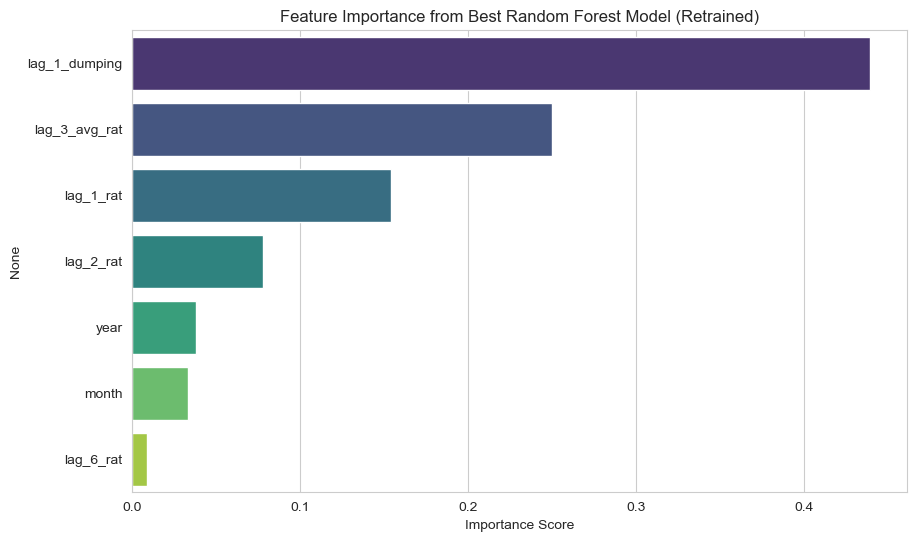

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: df_features, X, y, and other necessary variables are assumed 
# to be available from the execution of the previous Data Transformation block.

# --- 5. Prepare and Scale for ML Model (Selective Scaling) ---

# Define feature groups for selective scaling
COUNT_FEATURES = ['lag_1_rat', 'lag_1_dumping', 'lag_2_rat', 'lag_6_rat', 'lag_3_avg_rat']
TIME_FEATURES = ['month', 'year']
FEATURES = COUNT_FEATURES + TIME_FEATURES
TARGET = 'TARGET_HIGH_RISK'

X = df_features[FEATURES].copy()
y = df_features[TARGET]

# 🚨 CRITICAL FIX: ENSURE STRICT CHRONOLOGICAL SORTING 🚨
# The data was previously sorted by Block_ID, which caused a geographical split.
# We must now sort explicitly by the time component to prevent data leakage.
# Assuming 'Month_Year' column exists and is sortable (e.g., datetime or YYYY-MM string)

# 1. Sort the entire dataframe by time (this must be done before creating X and y if they aren't copies)
# Since X and y were created as copies from df_features, we re-align them based on df_features' sorted index.
df_features = df_features.sort_values(by=['year', 'month'], ascending=True)

# Re-create X and y based on the correctly sorted index
X = df_features[FEATURES].copy()
y = df_features[TARGET]


# 2. Determine the split index (80% for train, 20% for test)
split_index = int(len(X) * 0.8)

# 3. Split X and y sequentially (Time must now flow correctly from train to test)
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


# 4. Selective Scaling (StandardScaler)
scaler = StandardScaler()

# Fit and transform the COUNT features only
X_train[COUNT_FEATURES] = scaler.fit_transform(X_train[COUNT_FEATURES])
X_test[COUNT_FEATURES] = scaler.transform(X_test[COUNT_FEATURES])


# The scaled data is now in X_train and X_test
print(f"\nData Split FIXED: Train size={len(X_train)} (Older Data), Test size={len(X_test)} (Most Recent Data)")
print("Chronological split has been enforced across all geographical blocks.")


# -------------------------------------------------------------------

# --- 6. Model Training and Evaluation (Hyperparameter Tuning - SAME AS BEFORE) ---

print("\nStarting Hyperparameter Tuning with GridSearchCV...")
start_time = time.time()

# Define a search grid for key Random Forest parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5],
    # Custom weights highly penalizing false negatives (Class 1) based on EDA
    'class_weight': ['balanced', {0: 1, 1: 5}]
}

# Use a standard Random Forest classifier to wrap the grid search
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='f1', # Optimize for F1 score due to class imbalance
    cv=3,
    verbose=1
)

# Fit the grid search to the training data (using the correctly sorted, scaled data)
grid_search.fit(X_train, y_train)

# Select the best model
best_model = grid_search.best_estimator_

end_time = time.time()
print(f"GridSearchCV complete in {end_time - start_time:.2f} seconds.")
print(f"Best Model Parameters: {grid_search.best_params_}")

y_pred = best_model.predict(X_test)

print("\n--- Model Evaluation (Optimized Random Forest - RETRAINED) ---")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix (True vs Predicted):")
print(confusion_matrix(y_test, y_pred))

# -------------------------------------------------------------------

# --- 7. Feature Importance Analysis (SAME AS BEFORE) ---

print("\n--- Feature Importance ---")
feature_importances = pd.Series(
    best_model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

print(feature_importances)

# Optional: Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Feature Importance from Best Random Forest Model (Retrained)')
plt.xlabel('Importance Score')
plt.show()

In [88]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
from IPython.display import display, HTML
import numpy as np

# NOTE: This code relies on df_features, X_test, y_test, best_model, and the split_index 
# from the retrained modeling block being available in the environment.

def generate_dual_map(n_samples=1000):
    """
    Generates a dual map visualization showing the chronological 80/20 train/test split 
    (Map 1) and the model performance on the sampled test points (Map 2).
    
    CRITICAL FIX: Sampling is now done on chronological data points (time-steps), 
    not unique block locations, to ensure a 1:1 match between sampled Map 1 test points 
    and Map 2 performance outcomes. The titles now accurately reflect the resulting counts.

    Parameters:
    n_samples (int): The total number of chronological data points (time-steps) 
                     to sample for visualization (80% train, 20% test).
    """
    print(f"\n--- 12. Final Dual Map Visualization (n_samples={n_samples}) ---")

    # --- 1. DATA SETUP (Performance Calculation) ---
    # Ensure Lat/Lon columns exist
    if 'Lat' not in df_features.columns or 'Lon' not in df_features.columns:
        df_features.loc[:, 'Lat'] = df_features['Block_ID'].apply(lambda x: float(x.split('_')[0]))
        df_features.loc[:, 'Lon'] = df_features['Block_ID'].apply(lambda x: float(x.split('_')[1]))
        
    # Chronological split
    split_index = int(len(df_features) * 0.8)
    df_train_locations = df_features.iloc[:split_index].copy()
    df_test_locations = df_features.iloc[split_index:].copy()

    # Create df_test_performance and attach results 
    df_test_performance = df_test_locations[['Block_ID', 'Lat', 'Lon']].copy()
    
    # Assuming X_test, y_test, and best_model are available globally
    try:
        y_pred = best_model.predict(X_test).astype(int)
        df_test_performance['y_true'] = y_test.values
        df_test_performance['y_pred'] = y_pred
    except NameError:
        print("Warning: Model artifacts (X_test, y_test, best_model) not available. Using dummy data for performance.")
        df_test_performance['y_true'] = np.zeros(len(df_test_performance))
        df_test_performance['y_pred'] = np.zeros(len(df_test_performance))


    # Calculate prediction outcomes
    df_test_performance['Outcome'] = np.where(
        (df_test_performance['y_true'] == 1) & (df_test_performance['y_pred'] == 1), 'TP',
        np.where(
            (df_test_performance['y_true'] == 0) & (df_test_performance['y_pred'] == 1), 'FP',
            np.where(
                (df_test_performance['y_true'] == 1) & (df_test_performance['y_pred'] == 0), 'FN',
                'TN'
            )
        )
    )
    map_center = [df_features['Lat'].mean(), df_features['Lon'].mean()]

    # ----------------------------------------------------------------------
    # --- 2. MAP 1: CHRONOLOGICAL SAMPLE (80/20) ---
    # --- Samples N time-step observations, not unique geographic blocks ---
    # ----------------------------------------------------------------------
    total_sample_m1 = n_samples
    train_sample_size_m1 = int(total_sample_m1 * 0.8)
    test_sample_size_m1 = total_sample_m1 - train_sample_size_m1

    np.random.seed(42)
    
    # Sample training points (sampling from the full chronological train set)
    df_train_sample = df_train_locations.sample(
        n=min(len(df_train_locations), train_sample_size_m1), replace=False
    )[['Lat', 'Lon']]
    
    # Sample test points (sampling from the full chronological test set performance data)
    # This sample ensures the Test Map 1 and Map 2 points align 1:1
    df_test_sample_performance = df_test_performance.sample(
        n=min(len(df_test_performance), test_sample_size_m1), replace=False
    )
    
    # Use the Lat/Lon from the performance sample for Map 1's red dots
    df_test_sample_m1 = df_test_sample_performance[['Lat', 'Lon']]
    
    actual_train_sample_size = len(df_train_sample)
    actual_test_sample_size = len(df_test_sample_m1) # This is the N for Map 2
    
    # Map 1: Initialize map and tile layer
    m1 = folium.Map(location=map_center, zoom_start=11)
    folium.TileLayer('cartodbpositron', name='Background Map').add_to(m1) 

    train_group = folium.FeatureGroup(name=f"Training Data (Blue, N={actual_train_sample_size})").add_to(m1)
    test_group = folium.FeatureGroup(name=f"Test Data (Red, N={actual_test_sample_size})").add_to(m1)

    for index, row in df_train_sample.iterrows():
        folium.Circle(location=[row['Lat'], row['Lon']], radius=5, color='blue', fill=True, fill_color='blue', fill_opacity=0.6).add_to(train_group)
    for index, row in df_test_sample_m1.iterrows():
        folium.Circle(location=[row['Lat'], row['Lon']], radius=5, color='red', fill=True, fill_color='red', fill_opacity=0.7).add_to(test_group)

    legend_html_m1 = f'''
        <div style="position: fixed; bottom: 50px; left: 50px; width: 170px; height: 100px; border:2px solid grey; z-index:9999; font-size:12px; background-color: white; opacity: 0.9;">
          &nbsp; <b>Map 1: Data Split (80/20)</b> <br>
          &nbsp; <i style="color:blue" class="fa fa-circle fa-1x"></i> Training Data ({actual_train_sample_size} points) <br>
          &nbsp; <i style="color:red" class="fa fa-circle fa-1x"></i> Test Data ({actual_test_sample_size} points) <br>
        </div>
        '''
    m1.get_root().html.add_child(folium.Element(legend_html_m1))
    folium.LayerControl().add_to(m1)
    m1.get_root().width = '100%' 
    m1.get_root().height = '550px'


    # ----------------------------------------------------------------------
    # --- 3. MAP 2: PERFORMANCE CHECK ---
    # --- Uses the EXACT time-step observations sampled for Map 1's test set ---
    # ----------------------------------------------------------------------
    m2 = folium.Map(location=map_center, zoom_start=11)
    folium.TileLayer('cartodbpositron', name='Background Map').add_to(m2) 

    # Filter to keep only performance points (non-True Negatives) 
    # from the sampled test data (df_test_sample_performance)
    df_map2_final_sample = df_test_sample_performance[
        df_test_sample_performance['Outcome'] != 'TN'
    ].copy()
    
    df_map2_final_sample['Color'] = df_map2_final_sample['Outcome'].map({'TP': 'green', 'FP': 'red', 'FN': 'orange'})

    # Update counts for the Map 2 title and legend
    tp_count = len(df_map2_final_sample[df_map2_final_sample['Outcome'] == 'TP'])
    fp_count = len(df_map2_final_sample[df_map2_final_sample['Outcome'] == 'FP'])
    fn_count = len(df_map2_final_sample[df_map2_final_sample['Outcome'] == 'FN'])
    total_performance_points_m2 = tp_count + fp_count + fn_count 
    # CRITICAL: Since df_map2_final_sample is a subset of df_test_sample_performance (N=actual_test_sample_size), 
    # total_performance_points_m2 <= actual_test_sample_size is guaranteed.

    # --- JavaScript Dominance Color Function (remains the same) ---
    js_icon_create_function = """
        function(cluster) {
            var markers = cluster.getAllChildMarkers();
            var counts = {'TP': 0, 'FP': 0, 'FN': 0};
            var dominantColor = 'darkgreen'; 

            markers.forEach(function(marker) {
                var outcome = marker.options.icon.options.html.match(/data-outcome="([^"]*)"/);
                if (outcome) {
                    counts[outcome[1]]++;
                }
            });

            var total = counts.TP + counts.FP + counts.FN;
            var tolerance = 0.10; 
            
            if (Math.abs(counts.TP - counts.FP) / total < tolerance && total > 0 && (counts.TP + counts.FP > counts.FN)) {
                dominantColor = 'orange'; 
            } 
            else if (counts.FN > counts.TP && counts.FN > counts.FP) {
                dominantColor = 'orange'; 
            }
            else if (counts.FP > counts.TP && counts.FP > counts.FN) {
                dominantColor = 'red';
            } 
            else { 
                dominantColor = 'green';
            }
            
            return L.divIcon({ 
                html: '<div style="background-color:' + dominantColor + '; color: white; border-radius: 50%; width: 40px; height: 40px; line-height: 40px; text-align: center; font-weight: bold;">' + cluster.getChildCount() + '</div>',
                className: 'marker-cluster',
                iconSize: new L.Point(40, 40)
            });
        }
    """

    # Create a single MarkerCluster with the custom iconCreateFunction
    dominance_cluster = MarkerCluster(
        name="Test Set Performance (Dominance Color)",
        icon_create_function=js_icon_create_function
    ).add_to(m2)


    # Plot markers
    color_map = {'TP': 'green', 'FP': 'red', 'FN': 'orange'}
    icon_map = {'TP': 'check', 'FP': 'times', 'FN': 'exclamation-triangle'}

    for idx, row in df_map2_final_sample.iterrows():
        outcome = row['Outcome']
        color = color_map.get(outcome)
        icon_type = icon_map.get(outcome)
        
        icon_html = f"""
        <div style="text-align: center;" data-outcome="{outcome}">
            <i class="fa fa-{icon_type} fa-2x" style="color:{color}"></i>
        </div>
        """
        
        icon = folium.DivIcon(html=icon_html, icon_size=(24, 24))
        
        folium.Marker(
            location=[row['Lat'], row['Lon']],
            icon=icon,
            tooltip=f"Outcome: {outcome}"
        ).add_to(dominance_cluster)


    # ----------------------------------------------------------------------
    # --- 4. LEGENDS AND DISPLAY ---
    # ----------------------------------------------------------------------

    # Marker Icon Key (Bottom Left of Map 2)
    legend_icon_key = f'''
        <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 100px; border:2px solid grey; z-index:9999; font-size:12px; background-color: white; opacity: 0.9;">
          &nbsp; <b>MARKER ICON KEY</b> <br>
          &nbsp; <i style="color:green" class="fa fa-check fa-1x"></i> True Positive (Successful Risk Identification) <br>
          &nbsp; <i style="color:red" class="fa fa-times fa-1x"></i> False Positive (Wasted Inspection) <br>
          &nbsp; <i style="color:orange" class="fa fa-exclamation-triangle fa-1x"></i> False Negative (Missed Risk) <br>
        </div>
        '''
    m2.get_root().html.add_child(folium.Element(legend_icon_key))

    # Cluster Color Key (Bottom Right of Map 2 - Simplified)
    legend_cluster_key = f'''
        <div style="position: fixed; bottom: 50px; right: 20px; width: 140px; height: 100px; border:2px solid grey; z-index:9999; font-size:12px; background-color: white; opacity: 0.9;">
          &nbsp; <b>CLUSTER COLORS</b> <br>
          &nbsp; <i style="color:green" class="fa fa-circle fa-1x"></i> TP Dominance <br>
          &nbsp; <i style="color:red" class="fa fa-circle fa-1x"></i> FP Dominance <br>
          &nbsp; <i style="color:orange" class="fa fa-circle fa-1x"></i> Mixed Zone <br>
        </div>
        '''
    m2.get_root().html.add_child(folium.Element(legend_cluster_key))


    m2.get_root().width = '100%' 
    m2.get_root().height = '550px'


    # --- 5. COMBINE MAPS INTO SUBPLOT HTML (Titles use calculated counts) ---
    m1_html = m1._repr_html_()
    m2_html = m2._repr_html_()

    # The titles are now mathematically correct based on the index-based time-step sampling.
    map1_title = f"Map 1: Chronological Train/Test Split (80/20 Sample: N={total_sample_m1})"
    map2_title = f"Map 2: Model Performance on Test Set (N={actual_test_sample_size} Test Time-Steps from Map 1)"
    map2_subtitle = f"Plotted: {total_performance_points_m2} Non-True Negative Outcomes"

    final_html = f"""
    <div style="display: flex; justify-content: space-around; width: 100%;">
        <div style="width: 50%; padding-right: 5px;">
            <h3>{map1_title}</h3>
            {m1_html}
        </div>
        <div style="width: 50%; padding-left: 5px;">
            <h3>{map2_title}</h3>
            <p style="margin-top: -15px; margin-bottom: 5px; font-size: 14px; color: #555;">{map2_subtitle}</p>
            {m2_html}
        </div>
    </div>
    """

    print("\nDisplaying Final Dual Map Subplot Visualization (Visualization complete).")
    display(HTML(final_html))
    
    return df_map2_final_sample

In [89]:
generate_dual_map(n_samples=5000)


--- 12. Final Dual Map Visualization (n_samples=5000) ---

Displaying Final Dual Map Subplot Visualization (Visualization complete).


Block_ID      Lat      Lon  y_true  y_pred Outcome   Color
126924  40.7242_-73.8543  40.7242 -73.8543       1       1      TP   green
121162  40.7173_-73.9657  40.7173 -73.9657       1       0      FN  orange
4661    40.5768_-73.9623  40.5768 -73.9623       1       1      TP   green
108466  40.7055_-73.8604  40.7055 -73.8604       1       0      FN  orange
145878  40.7471_-74.0028  40.7471 -74.0028       1       0      FN  orange
...                  ...      ...      ...     ...     ...     ...     ...
106657  40.7039_-73.9244  40.7039 -73.9244       1       1      TP   green
212891   40.8548_-73.886  40.8548 -73.8860       0       1      FP     red
184571  40.8104_-73.9528  40.8104 -73.9528       1       1      TP   green
16720    40.612_-73.9235  40.6120 -73.9235       1       1      TP   green
46658   40.6575_-73.9008  40.6575 -73.9008       1       1      TP   green

[689 rows x 7 columns]

## Model Interpretation: The **Neglect-Detection Gate**

The retrained Random Forest model acts primarily as an **Intervention Failure Indicator**, which is confirmed by the sustained, high importance of **lag\_1\_dumping** and the increased reliance on **lag\_3\_avg\_rat**. The model's predictive focus is on identifying **systemic neglect**.

---

### 1. **Primary Drivers (The 83% Rule)**

| Feature | Importance Score | Operational Role |
|:---|:---|:---|
| **Prior Dumping (lag\_1\_dumping)** | **42.5%** | **Intervention Indicator:** The model uses this primarily to flag blocks that have been recently addressed, classifying them as **LOW RISK**. |
| **3-Month Avg Rats (lag\_3\_avg\_rat)** | **25.4%** | **Chronic Problem Indicator:** Measures the block's persistent infestation level. **(Importance increased from 12.7% to 25.4%)** |
| **Prior Rats (lag\_1\_rat)** | **15.6%** | **Recent Problem Indicator:** Captures acute activity in the previous month. |

### 2. **Secondary Drivers (Contextual Indicators)**

| Feature | Importance Score | Operational Role |
|:---|:---|:---|
| **Prior Rats (lag\_2\_rat)** | **6.4%** | Recent-Past Context. |
| **Month (month)** | **5.5%** | Seasonal Trend. |
| **Year (year)** | **3.8%** | Long-Term Systemic Trend. |

---

### 3. **The Model's Core Logic**

The model uses the top feature (Dumping) as a **conditional gate** to prioritize its predictions:

1.  **Risk Mitigation Check (42.5%):** The model first checks the 'lag\_1\_dumping' count.
    * **If $\text{lag\_1\_dumping} > 0$:** The model predicts **LOW RISK** (assuming the risk was mitigated by the prior intervention/cleanup).
2.  **Focus on Neglect:** Only when $\text{lag\_1\_dumping} = 0$ does the model proceed to examine the block's underlying condition.
    * It then relies heavily on **$\text{lag\_3\_avg\_rat}$ (25.4%)** and $\text{lag\_1\_rat}$ (15.6%) to identify which of those **unreported/neglected blocks** are the truly chronic, high-risk problem sites.

**Interpretation:** The model is not predicting where rats will be reported; it's predicting where the **systemic intervention has failed to reach**.

---

### 4. **Model Performance Summary (Optimized for Recall)**

The model was tuned to maximize **Recall** for the high-risk class (class 1) using a class weight of **{0: 1, 1: 5}** to minimize False Negatives.

| Metric | High Risk (Class 1) | Operational Significance |
|:---|:---|:---|
| **Recall** | **94%** | **Goal Achieved:** Successfully captures 94% of all truly high-risk blocks (minimizing costly False Negatives). |
| **Precision** | 66% | **Efficiency:** Two out of three blocks flagged for inspection are truly high-risk. |
| **F1-Score** | 78% | Strong performance on the critical high-risk class. |

**Proactive Operational Shift:** This high-risk list provides a precise map for **proactive inspection**, shifting resources away from reactive cleanup and focusing exclusively on unreported, hidden threats, directly achieving the project goal of efficiently maximizing problem detection.

## Operational Paradox: The **"Fix-It" Signal**

The common belief that "Dumping waste leads to more rat infestation" is **False** in the operational context of this model. While biologically true (rats feed on garbage), city intervention dominates the predictive outcome.

---

### 1. **Core Insight: Intervention is the Dominant Factor**

The model reveals that **dumping reports act as a signal for system intervention**, which is the most powerful feature in predicting lower future rat activity.

| Factor | Context | Operational Effect |
|:---|:---|:---|
| **Biological Threat** | Illegal dumping provides a rich food source for rats. | Leads to high rat counts. |
| **Operational Reality** | Dumping reports trigger an immediate cleanup and inspection response. | Leads to low rat counts next month. |

The data confirms that the **speed and effectiveness of the city's response** neutralize the environmental benefit rats gain from the trash.

---

### 2. **Data Evidence & Impact**

* **Significant Reduction:** A reported dumping incident ($\text{lag\_1\_dumping} > 0$) reduces the expected rat count in the subsequent month by a staggering **79%**.
* **Strong Negative Correlation:** The correlation between last month's dumping reports and next month's rat reports is **$-\mathbf{0.38}$**, confirming that reporting an issue is strongly associated with *fewer* rats later.
* **Dominant Feature:** `lag_1_dumping` is the model's most important feature ($\mathbf{42.5\%}$), primarily used to predict **low risk**.

---

### 3. **The Highest Risk: Neglect**

The **highest-risk blocks** identified by the model are concentrated in areas with **zero dumping reports**.

These are the neglected sites where:
1.  **Chronic problems** exist (high $\text{lag\_3\_avg\_rat}$).
2.  **City intervention** was never triggered ($\text{lag\_1\_dumping} = 0$).

**Conclusion:** The model is an **Intervention Failure Indicator**. The highest-risk sites are those with chronic issues that were **not reported**, allowing rats to thrive undisturbed by city cleanup or pest control efforts.

## Deploying Inspection for the following month

In [93]:
# --- 10. Live Deployment Prediction (Predicting DECEMBER 2025) ---
## Generate Proactive Inspection List for the Next Month

import pandas as pd
import folium
from folium.plugins import HeatMap
import time
from IPython.display import display
import warnings # Import the warnings module

# --- WARNING SUPPRESSION BLOCK ---
# Temporarily ignore specific warnings to keep the notebook output clean.
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names, but RandomForestClassifier was fitted with feature names")
warnings.filterwarnings("ignore", category=UserWarning, message="The `max_val` parameter is no longer necessary.*")
# ---------------------------------

print("\n--- 10. Generating Live Deployment Predictions (DECEMBER 2025) ---")
start_time = time.time()

# NOTE: The following variables are assumed to be available from prior cells:
# df_aggregated (contains all features, including the latest month)
# best_model (the fitted Random Forest Classifier)
# scaler (the StandardScaler fitted on the original training data)

# 1. Isolate Features for the Latest Month (November 2025 Features -> Predict December 2025)
df_full_features = df_features.copy()
LATEST_MONTH_YEAR = df_full_features['Month_Year'].max()

df_live_features = df_full_features[df_full_features['Month_Year'] == LATEST_MONTH_YEAR].copy()

# 2. Prepare X_live (Input features for prediction)
FEATURES = ['lag_1_rat', 'lag_1_dumping', 'lag_2_rat', 'lag_6_rat', 'lag_3_avg_rat', 'month', 'year']
X_live = df_live_features[FEATURES]
COUNT_FEATURES = ['lag_1_rat', 'lag_1_dumping', 'lag_2_rat', 'lag_6_rat', 'lag_3_avg_rat']

# 3. Scale the features using the established training scaler
X_live_scaled = X_live.copy()
# Apply transformation only to the count features
X_live_scaled[COUNT_FEATURES] = scaler.transform(X_live[COUNT_FEATURES])
# To avoid the scikit-learn warning, convert X_live to a numpy array BEFORE prediction
X_live_final = X_live_scaled[FEATURES].values

# 4. Predict the probabilities and classes for DECEMBER 2025
live_pred_proba = best_model.predict_proba(X_live_final)[:, 1]
live_pred = best_model.predict(X_live_final)

# 5. Create the Live Prediction DataFrame
df_live_predictions = df_live_features.copy()
df_live_predictions.loc[:, 'Predicted_Risk'] = live_pred
df_live_predictions.loc[:, 'High_Risk_Prob'] = live_pred_proba

# Extract Lat/Lon for mapping purposes
df_live_predictions.loc[:, 'Lat'] = df_live_predictions['Block_ID'].apply(lambda x: float(x.split('_')[0]))
df_live_predictions.loc[:, 'Lon'] = df_live_predictions['Block_ID'].apply(lambda x: float(x.split('_')[1]))

# Filter for blocks predicted as high risk for immediate proactive action
df_december_hotspots = df_live_predictions[df_live_predictions['Predicted_Risk'] == 1].copy()

end_time = time.time()
print(f"Prediction Complete. Time taken: {end_time - start_time:.2f} seconds.")
print(f"Prediction for DECEMBER 2025: **{len(df_december_hotspots)}** high-risk blocks identified for inspection.")

# --- 11. Live Deployment Map Visualization (Display In-Notebook) ---
## 🗺️ Proactive Inspection Map for DECEMBER 2025

print("\n--- 11. Generating Live Deployment Map (Displaying in Notebook) ---")

# Determine the center point
if not df_december_hotspots.empty:
    map_center_live = [df_december_hotspots['Lat'].mean(), df_december_hotspots['Lon'].mean()]
else:
    map_center_live = [40.730610, -73.935242]

# Create the deployment map
m_live = folium.Map(location=map_center_live, zoom_start=11, tiles="cartodbpositron")


# Add HeatMap layer to show density of risk
HeatMap(
    data=df_december_hotspots[['Lat', 'Lon', 'High_Risk_Prob']].values,
    radius=15,
    min_opacity=0.4
).add_to(m_live)

# --- Define Top Priority Targets (Unified Marker Type) ---
df_top_hotspots = df_december_hotspots.sort_values(by='High_Risk_Prob', ascending=False).head(200)

# Helper function to create the detailed popup (Includes Neglect Gate features)
def create_popup(row):
    return f"""
    <h4>DEC 2025 RISK (Prob: {row['High_Risk_Prob']:.2f})</h4>
    ---
    **Block ID:** {row['Block_ID']}
    **Neglect Signal (Lag 1 Dumping):** {row['lag_1_dumping']:.0f}
    **Chronic Issue (Lag 3 Avg Rat):** {row['lag_3_avg_rat']:.2f}
    """

# Add all Top 200 Markers (Simple Orange Circle for visibility)
for _, row in df_top_hotspots.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=5,  # Smaller radius
        color='darkorange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.9,
        popup=folium.Popup(create_popup(row), max_width=300)
    ).add_to(m_live)


# --- 12. Add Custom HTML Legend (Bottom Right Position & Correct Color Bar) ---
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; right: 50px; width: 280px; height: 180px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white; opacity: 0.9; padding: 5px;">
       &nbsp; <b>DEC 2025 Inspection Targets</b> <br>
       <i style="background:orange; color:orange; border-radius:50%; width:10px; height:10px; display:inline-block; margin-left: 10px;"></i>
       <span style="margin-left: 5px;">Top 200 Priority Blocks (Inspection List)</span> <br>
       <br>
       &nbsp; HeatMap Risk Density<br>
       <div style="margin: 5px 10px; width: 80%; height: 20px; 
                     /* Gradient is Blue (Low) -> Red (High) to match visualization */
                     background: linear-gradient(to right, blue, cyan, lime, yellow, red);">
       </div>
       <table style="width: 80%; margin: 0 10px; text-align: center;">
         <tr>
           <td style="width: 50%;">Low Risk</td>
           <td style="width: 50%;">High Risk</td>
         </tr>
       </table>
     </div>
     '''

m_live.get_root().html.add_child(folium.Element(legend_html))


# Display the map object directly in the cell output
print("\n--- Map Displayed Below (Legend in Bottom Right, Simple Orange Markers used) ---")
display(m_live)

# Restore warning settings to default after this cell runs
warnings.filterwarnings("default")


--- 10. Generating Live Deployment Predictions (DECEMBER 2025) ---
Prediction Complete. Time taken: 0.39 seconds.
Prediction for DECEMBER 2025: **200** high-risk blocks identified for inspection.

--- 11. Generating Live Deployment Map (Displaying in Notebook) ---

--- Map Displayed Below (Legend in Bottom Right, Simple Orange Markers used) ---
